# Chapter8 ニューラルネットワーク

## 準備

In [231]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import re
import keras
from keras import backend as K

In [0]:
base_dir = "./drive/My Drive/chap06".replace('/', os.sep)
W2V_FILE = "./drive/My Drive/chap07/data/GoogleNews-vectors-negative300.bin.gz"

In [0]:
N_DIM=300

In [0]:
TRAIN_FILE="/data/train.txt"
TEST_FILE ="/data/test.txt"

In [0]:
train_data = pd.read_csv(base_dir+TRAIN_FILE,sep="\t")
test_data = pd.read_csv(base_dir+TEST_FILE,sep="\t")

## 70 単語ベクトルの和による特徴量

In [0]:
from gensim.models import KeyedVectors

In [238]:
word2vec= KeyedVectors.load_word2vec_format(W2V_FILE,binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### 前処理

In [0]:
def remove_punctuation(s):
    """
    記号を取り除く
    """
    punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^','\n'
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']
    
    for p in punct:
        s = s.replace(p,"")
    return s

In [0]:
def remove_num(s):
    """
    数字を取り除く
    """
    return re.sub(r'\d+','',s)

In [0]:
def calc_ave_vec(s)->"vec":
    '''
    sentenceが入力されたとき、その分の各単語のvecを平均したものを返す
    ret->vec
    '''
    cnt=0
    ret_vec=np.zeros(N_DIM)
    for word in s.split( ):
        #word = word.lower()
        word = remove_num(word)
        word = remove_punctuation(word)
        try:
            word_vec = word2vec[word]
            ret_vec += word_vec
            cnt+=1
        except KeyError:
           # print("Unkown word->",word)
            pass
    return np.array([ret_vec/cnt])
            
           

In [0]:
def make_train_vec(data)->"matrix":
    '''
    pd.DataFrameを受け取って、その中のTITLE columns の各文をvectorにして、
    その二次元配列を返す
    df:
        (#id * vec(300))
    '''
    first=True
    for s in data["TITLE"]:
        if first:
            mat = np.array(calc_ave_vec(s))
            first=False
        else:
            mat = np.append(mat,calc_ave_vec(s),axis=0)
    print(mat.shape)
    return mat

In [0]:
def make_target_vec(data)->"matrix":
    """
    pd.DataFrameを受け取って、CATEGORY columnを抜き出して、
    値を数字に変換して matrixとして返す
    """
    ret = data["CATEGORY"]
    ret = ret.replace({"e":0,"b":1,"t":2,"m":3})
    ret = np.array(ret)
    print("mat->",ret.shape)
    return np.array(ret)

### vectorの作成

In [244]:
trainX = make_train_vec(train_data)

(12006, 300)


In [245]:
testX = make_train_vec(test_data)

(1334, 300)


In [246]:
trainY = make_target_vec(train_data)

mat-> (12006,)


In [247]:
testY = make_target_vec(test_data)

mat-> (1334,)


## 71 単層ニューラルネットワークによる予測

### y_1の計算

In [0]:
LEN=1
N_CATEGORY=4

In [249]:
x1 = trainX[0].reshape(LEN,N_DIM)
x1 = K.variable(x1)
x1.shape

TensorShape([Dimension(1), Dimension(300)])

In [250]:
W1 = np.random.randn(N_DIM,N_CATEGORY)
W1 = K.variable(W1)
W1.shape

TensorShape([Dimension(300), Dimension(4)])

In [251]:
xW = K.dot(x1,W1)
y1_pred = K.softmax(xW)
y1_pred.shape

TensorShape([Dimension(1), Dimension(4)])

In [252]:
K.get_value(y1_pred)

array([[0.05702861, 0.7466105 , 0.05160794, 0.14475289]], dtype=float32)

In [253]:
pred = K.argmax(y1_pred)
K.get_value(pred)

array([1])

In [254]:
#実際の答え
trainY[0]

2

### Yの計算

In [0]:
LEN=4
N_CATEGORY=4

In [256]:
X=trainX[:LEN].reshape(LEN,N_DIM)
X = K.variable(X)
X.shape

TensorShape([Dimension(4), Dimension(300)])

In [257]:
W = np.random.randn(N_DIM,N_CATEGORY)
W = K.variable(W)
W.shape

TensorShape([Dimension(300), Dimension(4)])

In [258]:
XW = K.dot(X,W)
Y_pred = K.softmax(XW)
Y_pred.shape

TensorShape([Dimension(4), Dimension(4)])

In [259]:
K.get_value(Y_pred)

array([[0.29509047, 0.14096364, 0.12889588, 0.43505004],
       [0.09277861, 0.2195845 , 0.6859786 , 0.00165834],
       [0.33297893, 0.1332643 , 0.5109394 , 0.0228173 ],
       [0.01563829, 0.7019886 , 0.18987052, 0.09250255]], dtype=float32)

In [260]:
pred=K.argmax(Y_pred,axis=1)
K.get_value(pred)

array([3, 2, 2, 1])

In [261]:
trainY[:4]

array([2, 0, 0, 2])

## 72 損失と勾配の計算

### 損失関数の計算

#### y_1 の損失

In [262]:
loss_y1 = K.categorical_crossentropy(K.variable(trainY[0]),y1_pred)
K.get_value(loss_y1)

array([16.10644], dtype=float32)

#### Yの損失

In [263]:
loss_Y = K.categorical_crossentropy(K.variable(trainY[:4]),Y_pred)
K.get_value(loss_Y)

array([ 4.105535, 17.558956,  9.759825, 13.077103], dtype=float32)

### 勾配の計算

#### y1の勾配

In [264]:
dw1 = K.gradients(loss_y1,W1)
print(dw1)
for d in dw1:
    print(K.get_value(d))

[<tf.Tensor 'gradients_9/MatMul_6_grad/MatMul_1:0' shape=(300, 4) dtype=float32>]
[[-0.09807704  0.2524006  -0.10083207 -0.05349147]
 [-0.02709472  0.06972808 -0.02785583 -0.01477753]
 [ 0.03081135 -0.0792928   0.03167685  0.01680459]
 ...
 [-0.00641772  0.01651597 -0.006598   -0.00350024]
 [-0.05356521  0.1378497  -0.05506988 -0.0292146 ]
 [ 0.01155295 -0.02973143  0.01187748  0.00630101]]


### Yの勾配

In [265]:
dw = K.gradients(loss_Y,W)
dw

[<tf.Tensor 'gradients_10/MatMul_7_grad/MatMul_1:0' shape=(300, 4) dtype=float32>]

##  73 確率勾配降下法による学習

In [0]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

In [0]:
model = Sequential()
model.add(Dense(4,activation="softmax",kernel_initializer="random_normal",use_bias=False))
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=SGD())

In [268]:
history=model.fit(trainX,trainY,epochs=10)

Epoch 1/10
12006/12006 [==============================] - 3s 279us/step - loss: 1.2486
Epoch 2/10
12006/12006 [==============================] - 1s 48us/step - loss: 1.0473
Epoch 3/10
12006/12006 [==============================] - 1s 49us/step - loss: 0.9398
Epoch 4/10
12006/12006 [==============================] - 1s 47us/step - loss: 0.8712
Epoch 5/10
12006/12006 [==============================] - 1s 47us/step - loss: 0.8222
Epoch 6/10
12006/12006 [==============================] - 1s 45us/step - loss: 0.7847
Epoch 7/10
12006/12006 [==============================] - 1s 45us/step - loss: 0.7544
Epoch 8/10
12006/12006 [==============================] - 1s 45us/step - loss: 0.7291
Epoch 9/10
12006/12006 [==============================] - 1s 45us/step - loss: 0.7073
Epoch 10/10
12006/12006 [==============================] - 1s 46us/step - loss: 0.6882


## 74 正解率の計測

In [269]:
model.evaluate(testX,testY)

1334/1334 [==============================] - 1s 894us/step


0.6824580558772566

## 75 損失と正解率のプロット

In [0]:
model = Sequential()
model.add(Dense(4,activation="softmax",kernel_initializer="random_normal"))
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=SGD(),
             metrics=["accuracy"])

In [0]:
history=model.fit(trainX,trainY,epochs=100,validation_data=(testX,testY),verbose=0)

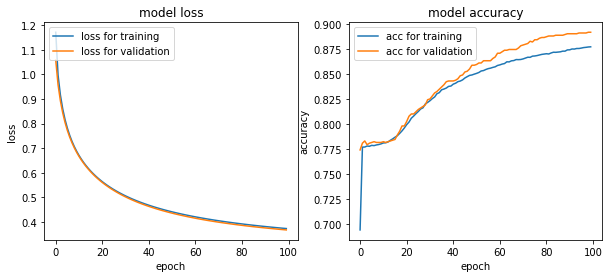

In [272]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

# loss
def plot_history_loss(fit):
    # Plot the loss in the history
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper left')

# acc
def plot_history_acc(fit):
    # Plot the loss in the history
    axR.plot(fit.history['acc'],label="acc for training")
    axR.plot(fit.history['val_acc'],label="acc for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper left')

plot_history_loss(history)
plot_history_acc(history)

## 76 チェックポイント

In [0]:
base_dir="./drive/My Drive/chap06/data/".replace("/",os.sep)

In [0]:
model = Sequential()
model.add(Dense(4,activation="softmax",kernel_initializer="random_normal"))
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=SGD(),
             metrics=["accuracy"])

In [0]:
checkpoint_path =base_dir+"checkpoint.ckpt"

In [0]:
cp_callback = ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [277]:
model.fit(trainX,trainY,epochs=10,validation_data=(testX,testY),verbose=0,callbacks=[cp_callback])


Epoch 00001: saving model to ./drive/My Drive/chap06/data/checkpoint.ckpt

Epoch 00002: saving model to ./drive/My Drive/chap06/data/checkpoint.ckpt

Epoch 00003: saving model to ./drive/My Drive/chap06/data/checkpoint.ckpt

Epoch 00004: saving model to ./drive/My Drive/chap06/data/checkpoint.ckpt

Epoch 00005: saving model to ./drive/My Drive/chap06/data/checkpoint.ckpt

Epoch 00006: saving model to ./drive/My Drive/chap06/data/checkpoint.ckpt

Epoch 00007: saving model to ./drive/My Drive/chap06/data/checkpoint.ckpt

Epoch 00008: saving model to ./drive/My Drive/chap06/data/checkpoint.ckpt

Epoch 00009: saving model to ./drive/My Drive/chap06/data/checkpoint.ckpt

Epoch 00010: saving model to ./drive/My Drive/chap06/data/checkpoint.ckpt


## 77 ミニバッチ化

In [0]:
import time

In [0]:
times=[]

In [280]:
for BATCH in list([2**v for v in range(0,10)]):
    model = Sequential()
    model.add(Dense(4,activation="softmax",kernel_initializer="random_normal"))
    model.compile(loss="sparse_categorical_crossentropy",
             optimizer=SGD(),
             metrics=["accuracy"])
    print("batch_size=",BATCH)
    start = time.time()
    model.fit(trainX,trainY,epochs=10,validation_data=(testX,testY),verbose=0,batch_size=BATCH)
    elapsed_time = time.time() - start
    print("time of 10 epochs is {}".format(elapsed_time))
    times.append(elapsed_time)
    print("-----------------------")

batch_size= 1
time of 10 epochs is 151.7273337841034
-----------------------
batch_size= 2
time of 10 epochs is 82.12994599342346
-----------------------
batch_size= 4
time of 10 epochs is 42.91698622703552
-----------------------
batch_size= 8
time of 10 epochs is 23.503328800201416
-----------------------
batch_size= 16
time of 10 epochs is 13.575230836868286
-----------------------
batch_size= 32
time of 10 epochs is 8.774829626083374
-----------------------
batch_size= 64
time of 10 epochs is 6.207744359970093
-----------------------
batch_size= 128
time of 10 epochs is 4.993463516235352
-----------------------
batch_size= 256
time of 10 epochs is 4.377787351608276
-----------------------
batch_size= 512
time of 10 epochs is 4.2405829429626465
-----------------------


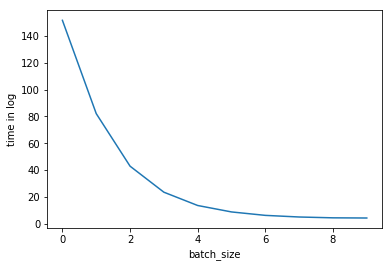

In [281]:
plt.xlabel("batch_size")
plt.ylabel("time in log")
plt.plot(times)

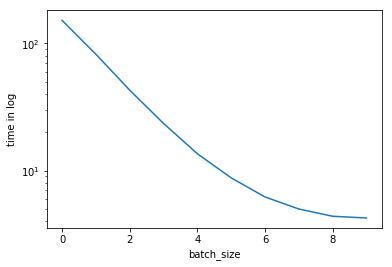

In [282]:
plt.yscale('log')
plt.xlabel("batch_size")
plt.ylabel("time in log")
plt.plot(times)

 ## 88 GPU上での学習

* kerasさんはGPUが利用可能な時に勝手に使ってくれるらしいから、colabのノートブックの設定しか、変更することがありません

## 89 多層ニューラルネットワーク

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

### dropout あり

In [0]:
HIDDEN=64
OUT_DIM=4

In [0]:
model = Sequential()
model.add(Dense(HIDDEN,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(HIDDEN,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(OUT_DIM,activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

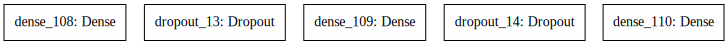

In [286]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
hist=model.fit(trainX,trainY,epochs=100,validation_data=(testX,testY),verbose=0,batch_size=126)

In [288]:
hist.history["acc"][-1]

0.9927536101712995

In [289]:
hist.history["val_acc"][-1]

0.9197901044113526

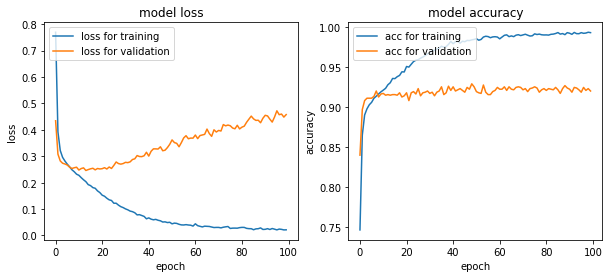

In [290]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
plot_history_loss(hist)
plot_history_acc(hist)

### drop out なし

In [0]:
model = Sequential()
model.add(Dense(HIDDEN,activation="relu"))
model.add(Dense(HIDDEN,activation="relu"))
model.add(Dense(OUT_DIM,activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

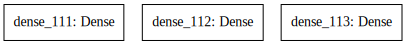

In [292]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
hist=model.fit(trainX,trainY,epochs=100,validation_data=(testX,testY),verbose=0,batch_size=126)

In [294]:
hist.history["acc"][-1]

0.9983341600941397

In [295]:
hist.history["val_acc"][-1]

0.9040479679693882

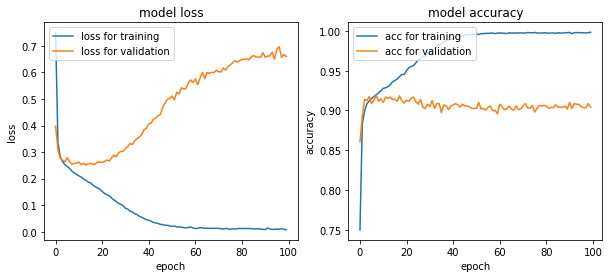

In [296]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
plot_history_loss(hist)
plot_history_acc(hist)